In [1]:
import pandas as pd
import dill
import numpy as np
from bokeh.plotting import figure, show
from bokeh.io import output_notebook,export_png
from bokeh.layouts import row
import bokeh.palettes as palettes 
from datetime import datetime
output_notebook()

Loading BokehJS ...

In [2]:
#Get results from first analysis
lstWeights,lstCols,lstReturnsLR,lstCovLR,lstfactBetasLR, lstfactInterceptsLR,lsterrEstLR,cols = dill.load(open('output/FinalProject_v3_LRVariables.db','rb'))
dfBmk = pd.read_csv('output/dfBmk_v3.csv',parse_dates=['MonthYear'])
dfEstLR = pd.read_csv('output/dfEstLR_v3.csv',parse_dates=['Date'])
dfActLR = pd.read_csv('output/dfActLR_v3.csv',parse_dates=['Date'])
dfSecRtn = pd.read_csv('output/dfSecRtn_v3.csv',parse_dates=['Date'])
dfFamaData = pd.read_csv('output/dfFamaData_v3.csv',parse_dates=['YearMonth'])
dfConstList = pd.read_csv('output/dfConstList_v3.csv')

#Bayes results
dfEstB = pd.read_csv('output/dfEstB_v3.csv',parse_dates=['Date'])
dfActB = pd.read_csv('output/dfActB_v3.csv',parse_dates=['Date'])
lstWeightsB,lstReturnsB,lstCovB,lstfactBetasB, lstfactInterceptsB,lsterrEstB = dill.load(open('output/FinalProject_v3_BayesVariables.db','rb'))

dfBmk.set_index('MonthYear', inplace=True)
dfSecRtn.set_index('Date', inplace=True)
dfFamaData.set_index('YearMonth', inplace=True)
dfActLR.set_index('Date', inplace=True)
dfEstLR.set_index('Date', inplace=True)
dfActB.set_index('Date', inplace=True)
dfEstB.set_index('Date', inplace=True)
dfActLR.drop(['Unnamed: 0'],axis=1, inplace=True)
dfEstLR.drop(['Unnamed: 0'],axis=1, inplace=True)
dfActB.drop(['Unnamed: 0'],axis=1, inplace=True)
dfEstB.drop(['Unnamed: 0'],axis=1, inplace=True)

In [3]:
dfRtn = []

for i,v in enumerate(lstCols):
    
    tmpdf = pd.DataFrame(data=np.concatenate((np.full((100,1),lstReturnsLR[i][0]),np.asarray(v).reshape(-1,1),lstReturnsLR[i][1].reshape(-1,1),lstReturnsB[i][1].reshape(-1,1)), axis=1), columns=['Date','Entity','LREstRtn','BEstRtn'])
    tmpact = dfSecRtn.loc[dfSecRtn.index.floor('D').isin([lstReturnsLR[i][0].strftime('%Y-%m-%d')]),tmpdf['Entity']]
    tmpact = tmpact.T.reset_index()
    tmpact.columns = ['Entity', 'ActRtn']
    tmpdf2 = pd.merge(tmpdf, tmpact, on=['Entity'])
    dfRtn.append(tmpdf2)
dfEstRtnAll = pd.concat(dfRtn, axis=0)  
dfEstRtnAll.reset_index(drop=True, inplace=True)    

In [4]:
#dfSecRtn[datetime(dfEstRtnAll.loc[0,'Date'].strftime('%Y-%m-%d'))]
#dfEstRtnAll.loc[0,'Date'].strftime('%Y-%m-%d')
#pd.to_datetime(dfEstRtnAll.loc[0,'Date']
dfEstRtnAll['MSELR'] = pd.to_numeric((dfEstRtnAll['ActRtn'] - dfEstRtnAll['LREstRtn'])**2)
dfEstRtnAll['MSEB'] = pd.to_numeric((dfEstRtnAll['ActRtn'] - dfEstRtnAll['BEstRtn'])**2)
dfStats = dfEstRtnAll[['Date','MSELR', 'MSEB']].groupby('Date').mean()
dfStats

,MSELR,MSEB
Date,,
2008-12-01,150.087919,148.466907
2009-01-01,118.300165,127.633878
2009-02-01,176.307827,178.780995
2009-03-01,422.453346,423.061794
2009-04-01,451.484520,472.054768
...,...,...
2019-04-01,52.922093,50.910377
2019-05-01,53.381920,53.665620
2019-06-01,35.254900,34.167570


In [5]:
dfEstRtnAll['MSELR'] - dfEstRtnAll['MSEB']

0          0.517924
1          2.005361
2         -5.783556
3          3.344422
4         -1.652210
            ...    
12895    151.784236
12896     -2.969211
12897     -1.219884
12898     -0.874612
12899     -3.976333
Length: 12900, dtype: float64

In [6]:
difMSE = dfEstRtnAll['MSELR'] - dfEstRtnAll['MSEB']
pBC = figure(title="MSE Difference Bayes vs LR", toolbar_location=None, x_axis_type='datetime')
pBC.vbar(x=difMSE.index, top=difMSE , width=1)
export_png(pBC, filename="plot.png")
show(pBC)

In [7]:
difMSE[difMSE>0].count()/difMSE.count()

0.5282170542635659

In [8]:
dfEstRtnAll.loc[417]

Date        2009-04-01 00:00:00
Entity                 000PC2-E
LREstRtn                65.5177
BEstRtn                 60.0942
ActRtn                  180.032
MSELR                   13113.5
MSEB                    14385.1
Name: 417, dtype: object

In [9]:
#Return analysis between predicted return weights and Index
dfStats['difStats'] = dfStats.MSELR - dfStats.MSEB
pBC = figure(title="MSE Difference Bayes vs LR", toolbar_location=None, x_axis_type='datetime')
pBC.vbar(x=dfStats.index, top=dfStats.difStats , width=1)
export_png(pBC, filename="plot.png")
show(pBC)

In [10]:
dfStats['difStats'][dfStats['difStats']>0].count()/dfStats['difStats'].count()

0.7364341085271318

In [11]:
dfStats.mean()

MSELR       61.275305
MSEB        60.597237
difStats     0.678067
dtype: float64

In [12]:
#get the constituent counts
dfPortCount = pd.DataFrame([ (w[0], sum([np.round(c,2) > 0 for c in w[1]['weight']])) for w in lstWeights], columns=['Date','Count'])
#get the difference in returns this is the error we are looking to minimize
dfDifLR = pd.DataFrame(np.subtract(dfActLR.Rtn, dfEstLR.Rtn), columns=['Rtn'])
MAE_LR = np.sum(abs(dfDifLR))/len(dfDifLR)
RMSE_LR = np.sqrt(np.sum(dfDifLR**2)/dfDifLR.size)
MSELR =  np.mean(np.subtract(abs(dfActLR.Rtn),abs(dfEstLR.Rtn))**2)
MAPE_LR = np.sum(abs((dfActLR - dfEstLR)/dfActLR))/dfActLR.size*(1/100)
SMAPE_LR = np.sum(abs(dfEstLR-dfActLR))/np.sum(dfEstLR+dfActLR)
CumErr_LR = (np.cumprod(1+dfEstLR.Rtn/100)*100)/(np.cumprod(1+dfActLR.Rtn/100)*100)

MSELR =  np.mean(np.subtract(np.log(1+ dfActLR.Rtn/100),np.log(1 + dfEstLR.Rtn/100))**2)*100

#dfEstLR.Rtn.abs().sum()/dfActLR.Rtn.abs().sum()

In [13]:
print(MAPE_LR)
print(MAE_LR)
MSELR



Rtn    0.08714
dtype: float64
Rtn    4.758988
dtype: float64


0.3585096192563158

In [14]:
#Return analysis between predicted return weights and Index
dfMSELR = pd.DataFrame(np.subtract(abs(dfActLR.Rtn),abs(dfEstLR.Rtn))**2, columns=['Rtn'])

pBC = figure(title="MSE Linear Regression", toolbar_location=None, x_axis_type='datetime')
pBC.vbar(x=dfMSELR.index, top=dfMSELR.Rtn , width=1)
export_png(pBC, filename="plot.png")
show(pBC)

In [15]:
dfMSELR.head()

,Rtn
Date,
2009-01-01,15.786654
2009-02-01,0.004545
2009-03-01,30.715706
2009-04-01,6.717390
2009-05-01,165.244415


In [16]:
AnnRtnLR = ((np.prod((1 + dfActLR/100)**(12/len(dfActLR))) -1)*100)
AnnRtnBayes = ((np.prod((1 + dfActB/100)**(12/len(dfActB))) -1)*100)
AnnRtnBmk = ((np.prod((1 + dfBmk.RETURN/100)**(12/len(dfBmk.RETURN))) -1)*100)
AnnStdLR = (((1 + dfActLR/100)-1).std() * np.sqrt(12/len(dfActLR))*100)
AnnStdBayes = ( ((1 + dfActB/100) -1).std() * np.sqrt(12/len(dfActB))*100)
AnnRtnELR = ((np.prod((1 + dfEstLR/100)**(12/len(dfEstLR))) -1)*100)
AnnRtnEBayes = ((np.prod((1 + dfEstB/100)**(12/len(dfEstB))) -1)*100)
AnnStdELR = (((1 + dfEstLR/100)-1).std() * np.sqrt(12/len(dfEstLR))*100)
AnnStdEBayes = ( ((1 + dfEstB/100) -1).std() * np.sqrt(12/len(dfEstB))*100)

In [17]:
print('Estimated Values')
print ('LR Annualized Rtn % 5.4f' %AnnRtnELR)
print ('Bayes Annualized Rtn  % 5.4f' % AnnRtnEBayes)
print('LR Annualized Volatility % 5.4f' %AnnStdELR)
print('Bayes Annualized Volatility  % 5.4f' %AnnStdEBayes)
print('LR Sharpe Ratio % 5.4f' %(dfEstLR.mean()/AnnStdELR))
print('Bayes Sharpe Ratio  % 5.4f' %(dfEstB.mean()/AnnStdEBayes))

print('Actual Values')

print ('LR Annualized Rtn % 5.4f' %AnnRtnLR)
print ('Bayes Annualized Rtn  % 5.4f' % AnnRtnBayes)
print ('BMK Annualized Rtn  % 5.4f' % AnnRtnBmk)
print('LR Annualized Volatility % 5.4f' %AnnStdLR)
print('Bayes Annualized Volatility  % 5.4f' %AnnStdBayes)
print('LR Sharpe Ratio % 5.4f' %(dfActLR.mean()/AnnStdLR))
print('Bayes Sharpe Ratio  % 5.4f' %(dfActB.mean()/AnnStdBayes))

Estimated Values
LR Annualized Rtn  29.4941
Bayes Annualized Rtn   24.6043
LR Annualized Volatility  1.2797
Bayes Annualized Volatility   1.2901
LR Sharpe Ratio  1.7684
Bayes Sharpe Ratio   1.5019
Actual Values
LR Annualized Rtn  14.9959
Bayes Annualized Rtn   18.9897
BMK Annualized Rtn   6.8188
LR Annualized Volatility  1.2416
Bayes Annualized Volatility   1.5506
LR Sharpe Ratio  1.0090
Bayes Sharpe Ratio   1.0226


In [18]:
#get the constituent counts
dfPortCountB = pd.DataFrame([ (w[0], sum([np.round(c,2) > 0 for c in w[1]['weight']])) for w in lstWeightsB], columns=['Date','Count'])
#get the difference in returns this is the error we are looking to minimize
dfDifB = pd.DataFrame(np.subtract(dfActB.Rtn,dfEstB.Rtn), columns=['Rtn'])
MAE_B = np.sum(abs(dfDifB))/len(dfDifB)
RMSE_B = np.sqrt(np.sum(dfDifB**2)/dfDifB.size)
MSEB = np.mean(np.subtract(abs(dfActB.Rtn),abs(dfEstB.Rtn))**2)
MAPE_B = np.sum(abs((dfActB - dfEstB)/dfActB))/dfActB.size*(1/100)
SMAPE_B = np.sum(abs(dfEstB-dfActB))/np.sum(dfEstB+dfActB)

CumErr_B = (np.cumprod(1+dfEstB.Rtn/100)*100)/(np.cumprod(1+dfActB.Rtn/100)*100)

MSEB =  np.mean(np.subtract(np.log(1 + dfEstB.Rtn/100),np.log(1+ dfActB.Rtn/100))**2)*100

In [19]:
SMAPE_B
MAE_B
MSEB


0.4259016369450014

In [20]:
dfDifB

,Rtn
Date,
2009-01-01,-9.566092
2009-02-01,0.728981
2009-03-01,20.149517
2009-04-01,13.995613
2009-05-01,-10.585033
...,...
2019-05-01,-16.418869
2019-06-01,13.260253
2019-07-01,-6.024017


In [21]:
dfPortWeights = pd.DataFrame([ (w[0], np.mean([np.round(c,2)  for c in w[1]['weight'] if np.round(c,2)>0]),min([np.round(c,2) for c in w[1]['weight'] if np.round(c,2)>0]),max([np.round(c,2) for c in w[1]['weight']])) for w in lstWeights], columns=['Date','Mean', 'Min','Max'])

In [22]:
dfPortWeights = pd.DataFrame([ (w[0], [np.round(c,2)  for c in w[1]['weight'] if np.round(c,2)>0]) for w in lstWeightsB], columns=['Date','Wght'])
dfPortWeights = pd.DataFrame([(np.mean(m), min(m), max(m)) for m in dfPortWeights['Wght']], columns=['mean','min','max'])

In [23]:
dfPortWeights.describe()

,mean,min,max
count,129.000000,1.290000e+02,129.000000
mean,0.026505,1.000000e-02,0.081628
std,0.003446,6.965946e-18,0.021020
min,0.014194,1.000000e-02,0.030000
25%,0.024500,1.000000e-02,0.070000
50%,0.026486,1.000000e-02,0.080000
75%,0.028824,1.000000e-02,0.090000
max,0.034138,1.000000e-02,0.150000


#### Show constituent counts after Optimizer ran

In [24]:
pB = figure(title="Bayes Constituent Counts", toolbar_location=None, x_axis_type='datetime')
pB.vbar(x=dfPortCountB.Date, top=dfPortCountB.Count , width=.9)
pLR = figure(title="LR Constituent Counts", toolbar_location=None, x_axis_type='datetime')
pLR.vbar(x=dfPortCount.Date, top=dfPortCount.Count , width=.9)
export_png(pB, filename="plot.png")
show(row(pLR, pB) )

In [25]:
pLRC = figure(title="LR Difference between predicted return for period and actual return", toolbar_location=None, x_axis_type='datetime')
pLRC.vbar(x=dfDifLR.index, top=dfDifLR.Rtn , width=1)
pBC = figure(title="BayesDifference between predicted return for period and actual return", toolbar_location=None, x_axis_type='datetime')
pBC.vbar(x=dfDifB.index, top=dfDifB.Rtn , width=1)
show(row(pLRC, pBC))

In [26]:
#Return analysis between predicted return weights and Index
dfMSEB = pd.DataFrame(np.subtract(abs(dfActB.Rtn),abs(dfEstB.Rtn))**2, columns=['Rtn'])

pBC = figure(title="Bayes Regression", toolbar_location=None, x_axis_type='datetime')
pBC.vbar(x=dfMSEB.index, top=dfMSEB.Rtn , width=1)
export_png(pBC, filename="plot.png")
show(pBC)

In [27]:
#Return analysis between predicted return weights and Index
colors = palettes.all_palettes['Set1'][5]
p = figure(title="Return Comparison", toolbar_location=None, x_axis_type='datetime')

p.line(x=dfBmk[dfEstLR.index.min():].index, y=np.cumprod(1+dfBmk[dfEstLR.index.min():].RETURN/100)*100, color=colors[0], legend='R1000', line_width=2)
#p.line(x=dfEstLR.index, y=np.cumprod(1+dfEstLR.Rtn/100)*100,  color=colors[1],legend='LR Expected Return', line_width=2)
#p.line(x=dfActLR.index, y=np.cumprod(1+dfActLR.Rtn/100)*100,  color=colors[2],legend='LR Actual Return', line_width=2)
p.line(x=dfEstB.index, y=np.cumprod(1+dfEstB.Rtn/100)*100,  color=colors[3],legend='Bayes Expected Return', line_width=2)
p.line(x=dfActB.index, y=np.cumprod(1+dfActB.Rtn/100)*100,  color=colors[4],legend='Bayes Actual Return', line_width=2)
p.legend.location = "top_left"
export_png(p, filename="plot.png")
show(p)

In [28]:
print(np.prod(1+dfEstLR.Rtn/100)*100)
print(np.prod(1+dfActLR.Rtn/100)*100)
print(np.prod(1+dfEstB.Rtn/100)*100)
np.prod(1+dfActB.Rtn/100)*100

1609.484077842264
449.0909306133517
1064.0909173321027


648.2268499943215

In [29]:
#Return analysis between predicted return weights and Index
colors = palettes.all_palettes['Set1'][5]
p = figure(title="Return Comparison", toolbar_location=None, x_axis_type='datetime')

#p.line(x=dfBmk[dfEstLR.index.min():].index, y=np.cumprod(1+dfBmk[dfEstLR.index.min():].RETURN/100)*100, color=colors[0], legend='R1000', line_width=2)
p.line(x=dfDifLR.index, y=dfDifLR.Rtn,  color=colors[1],legend='LR Expected Return', line_width=2)
p.line(x=dfActLR.index, y=dfActLR.Rtn,  color=colors[2],legend='LR Actual Return', line_width=2)
#p.line(x=dfEstB.index, y=np.cumprod(1+dfEstB.Rtn/100)*100,  color=colors[3],legend='Bayes Expected Return', line_width=2)
#p.line(x=dfActB.index, y=np.cumprod(1+dfActB.Rtn/100)*100,  color=colors[4],legend='Bayes Actual Return', line_width=2)
p.legend.location = "top_left"
export_png(p, filename="plot.png")
show(p)

In [30]:
#Return analysis between predicted return weights and Index
colors = palettes.all_palettes['Set1'][5]
p = figure(title="LR Error", toolbar_location=None, x_axis_type='datetime')
pBC = figure(title="Bayes Error", toolbar_location=None, x_axis_type='datetime')
p.line(x=dfDifB.index, y=np.cumprod(1+dfDifB.Rtn/100)*100,  color=colors[1],legend='Bayes Error', line_width=2)
p.line(x=dfDifLR.index, y=np.cumprod(1+dfDifLR.Rtn/100)*100,  color=colors[2],legend='LR Error', line_width=2)

p.legend.location = "top_left"
show(p)

In [31]:
dfDifB.std()

Rtn    6.627377
dtype: float64

In [32]:
w =  lstWeightsB[0][1][[np.round(c,2) > 0.0 for c in lstWeightsB[0][1]['weight']]].copy()
pw = figure(title="Bayes Weights", toolbar_location=None, x_range=w['Entity'])
pw.xaxis.major_label_orientation = np.pi/4
pw.vbar(x=w['Entity'], top=w['weight'], width=1)
show(pw)

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline

In [34]:
combined_returns = pd.concat([dfBmk.RETURN.rename('bm'), dfActLR.Rtn.rename('LR'), dfActB.Rtn.rename('Bayes')], axis=1).dropna()

In [35]:
combined_returns.corr()

,bm,LR,Bayes
bm,1.000000,-0.078976,-0.030302
LR,-0.078976,1.000000,0.912332
Bayes,-0.030302,0.912332,1.000000


In [36]:

combined_returns.sub(dfFamaData.loc[combined_returns.index.min():combined_returns.index.max(),'RF'], axis=0).mean()/combined_returns.std()*np.sqrt(12)

bm       1.004648
LR       1.034385
Bayes    1.055014
dtype: float64

In [37]:
combined_returns.describe()

,bm,LR,Bayes
count,129.000000,129.000000,129.000000
mean,1.195790,1.252815,1.585553
std,3.994871,4.071000,5.083931
min,-10.338670,-8.774596,-11.429945
25%,-1.072743,-0.774089,-0.868970
50%,1.597903,1.521444,1.670436
75%,3.486946,3.974943,4.620826
max,11.208833,13.103813,24.216113


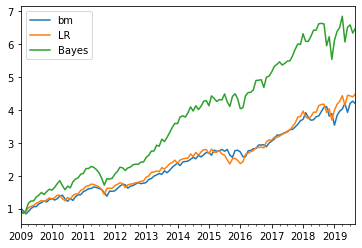

In [38]:
(combined_returns/100 +1).cumprod().plot()